In [123]:
from scipy.linalg.lapack import dpotrf, dpotri
import numpy as np
from sunbird.inference.priors import Yuan23, AbacusSummit


def invert_symmetric_positive_semidefinite_matrix(m):
    r"""Invert a symmetric positive sem-definite matrix. This function is
    faster than numpy.linalg.inv but does not work for arbitrary matrices.
    Attributes
    ----------
    m : numpy.ndarray
        Matrix to be inverted.
    Returns
    -------
    m_inv : numpy.ndarray
        Inverse of the matrix.
    """

    m_inv = dpotri(dpotrf(m, False, False)[0])[0]
    m_inv = np.triu(m_inv) + np.triu(m_inv, k=1).T
    return m_inv


def minimum_volume_enclosing_ellipsoid(points, tol=0, max_iterations=1000):
    r"""Find an approximation to the minimum bounding ellipsoid to:math:`m`
    points in :math:`n`-dimensional space using the Khachiyan algorithm.
    This function is based on
    http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.116.7691 but
    implemented independently of the corresponding MATLAP implementation or
    other Python ports of the MATLAP code.
    Attributes
    ----------
    points : numpy.ndarray with shape (m, n)
        A 2-D array where each row represents a point.
    Returns
    -------
    c : numpy.ndarray
        The position of the ellipsoid.
    A : numpy.ndarray
        The bounds of the ellipsoid in matrix form, i.e.
        :math:`(x - c)^T A (x - c) \leq 1`.
    """

    m, n = points.shape
    q = np.append(points, np.ones(shape=(m, 1)), axis=1)
    u = np.repeat(1.0 / m, m)
    q_outer = np.array([np.outer(q_i, q_i) for q_i in q])
    e = np.diag(np.ones(m))

    for i in range(max_iterations):
        if i % 1000 == 0:
            v = np.einsum('ji,j,jk', q, u, q)
        g = np.einsum('ijk,jk', q_outer,
                      invert_symmetric_positive_semidefinite_matrix(v))
        j = np.argmax(g)
        d_u = e[j] - u
        a = (g[j] - (n + 1)) / ((n + 1) * (g[j] - 1))
        shift = np.linalg.norm(a * d_u)
        v = v * (1 - a) + a * q_outer[j]
        u = u + a * d_u
        if shift <= tol:
            break

    c = np.einsum('i,ij', u, points)
    A_inv = (np.einsum('ji,j,jk', points, u, points) - np.outer(c, c)) * n
    A = np.linalg.inv(A_inv)

    scale = np.amax(np.einsum('...i,ij,...j', points - c, A, points - c))
    A /= scale

    return c, A

def check_summit_range(p, prior_c, prior_A):
    return np.einsum('...i,ij,...j', p - prior_c, prior_A, p - prior_c) <= 1

def get_priors(cosmo=True, hod=True):
    stats_module = 'scipy.stats'
    priors, ranges, labels = {}, {}, {}
    if cosmo:
        priors.update(AbacusSummit(stats_module).priors)
        ranges.update(AbacusSummit(stats_module).ranges)
        labels.update(AbacusSummit(stats_module).labels)
    if hod:
        priors.update(Yuan23(stats_module).priors)
        ranges.update(Yuan23(stats_module).ranges)
        labels.update(Yuan23(stats_module).labels)
    return priors, ranges, labels


#read in omega_b, omega_cdm, A_s, n_s of summit cosmology grid
cosmo_table_fn = "/global/cfs/cdirs/desicollab/users/epaillas/code/sunbird/sunbird/inference/priors/summit_cosmologies.txt"


params = ['omega_b', 'omega_cdm', 'sigma8_m', 'n_s', 'alpha_s', 'N_ur', 'w0_fld', 'wa_fld']
df = pandas.read_csv(cosmo_table_fn, delimiter=',')
df.columns = df.columns.str.strip()
df.columns = list(df.columns.str.strip('# ').values)
summit_cosmology_table = np.c_[[df[param] for param in params]].T
print(summit_cosmology_table.shape)

# summit_cosmology_table = np.genfromtxt(
#     cosmo_table_fn, delimiter=',')[:,[2,3,5,6]]
# priors, ranges, labels = get_priors(cosmo=True, hod=False)

# you can now draw the envelope with this
prior_c, prior_A = minimum_volume_enclosing_ellipsoid(summit_cosmology_table)

(52, 8)


In [124]:
np.random.normal(loc=0, scale=1)

-0.0730734620404763

In [125]:
def sample_uniform_priors():
    sample = []
    for param in priors.keys():
        sample.append(priors[param].rvs())
    return np.array(sample)

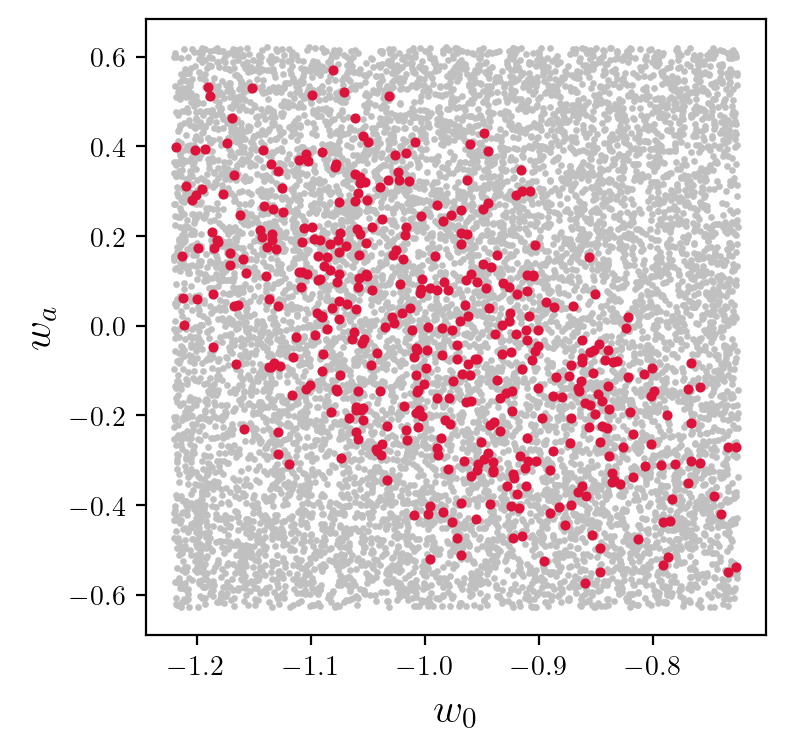

In [104]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='Helvetica')

fig, ax = plt.subplots(figsize=(4, 4))

for i in range(10000):
    sample = sample_uniform_priors()
    
    ax.scatter(sample[-2], sample[-1], s=2.0, color='silver')

for i in range(10000):
    sample = sample_uniform_priors()
    
    if check_summit_range(sample, prior_c, prior_A):
        ax.scatter(sample[-2], sample[-1], s=7.0, color='crimson')

ax.set_xlabel(r'$w_0$', fontsize=15)
ax.set_ylabel(r'$w_a$', fontsize=15)
plt.show()
# check_summit_range(sample, prior_c, prior_A)

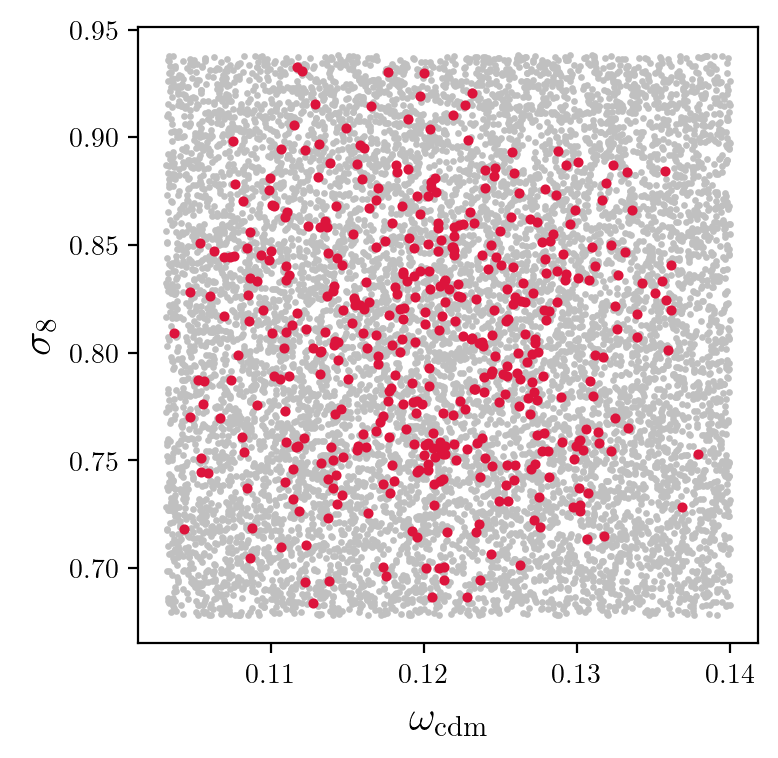

In [126]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='Helvetica')

fig, ax = plt.subplots(figsize=(4, 4))

for i in range(10000):
    sample = sample_uniform_priors()
    
    ax.scatter(sample[1], sample[2], s=2.0, color='silver')

for i in range(10000):
    sample = sample_uniform_priors()
    
    if check_summit_range(sample, prior_c, prior_A):
        ax.scatter(sample[1], sample[2], s=7.0, color='crimson')

ax.set_xlabel(r'$\omega_{\rm cdm}$', fontsize=15)
ax.set_ylabel(r'$\sigma_8$', fontsize=15)
plt.show()
# check_summit_range(sample, prior_c, prior_A)